# <center> CS559 Homework#3: Decision Tree and Ensemble Methods</center>
## <center> Due: 11/8/2021 Monday at 11:59 PM</center>


In this assignment, you are going to implement four classifiers - **decision tree, random forest, adaboost, and gradient boost**. 
Then check the performance with `sklearn` built-in algorithms.
In this work, splitting into train and test sets is not necessary. 

The provided data has four columns - three features (a, b, and c) and the target (class). Three features are continuous data and the target is a binary, 0 or 1. 

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

In [23]:
metrics_dict = {'model_type': [], 'score': []}
random_state = 10

In [24]:
original_df = pd.read_csv('./F21_CS559_HW3_data.csv')

In [25]:
original_df.head(5)

,a,b,c,class
0,9.4202,-4.3507,10.3764,1
1,9.7044,-4.4601,10.6803,1
2,9.8075,-4.0894,10.6259,1
3,9.2771,-4.0349,10.1166,1
4,9.6447,-3.5968,10.2936,1


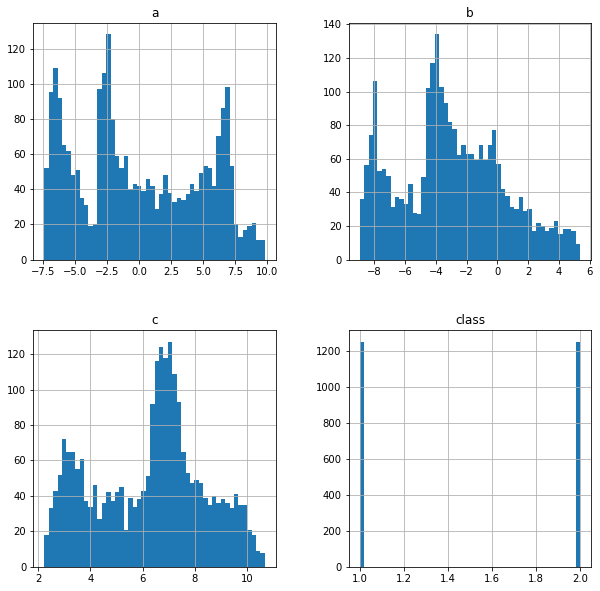

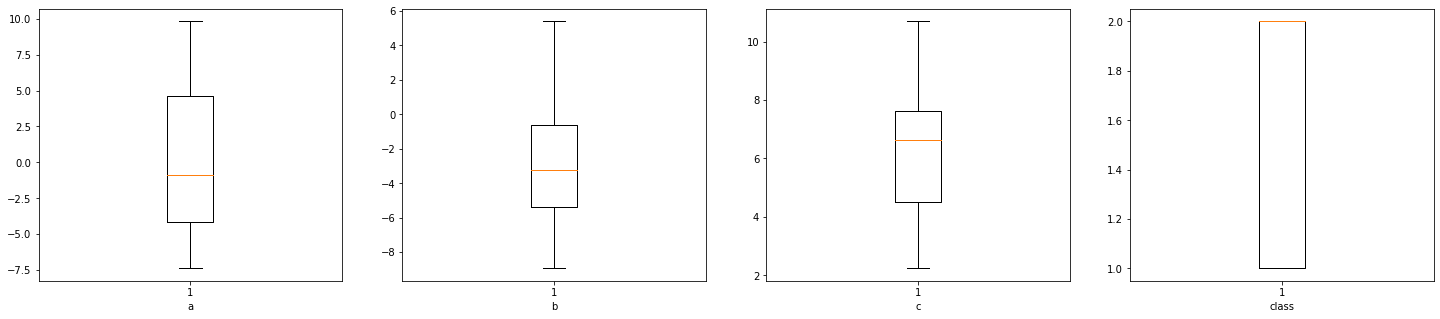

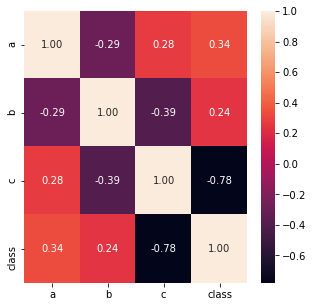

In [26]:
class EDA:
    def __init__(self, df):
        self.df = df
        self.get_vif_df()
        self.graph_hist()
        self.graph_box_plot()
        self.graph_correlation()
        
    def get_vif_df(self): 
        return pd.DataFrame(np.linalg.inv(self.df.corr().values), index = self.df.corr().index, 
                            columns = self.df.columns)

    def graph_hist(self):
        self.df.hist(bins = 50, figsize = (10,10))
        plt.show()

    def graph_box_plot(self):
        fig, ax = plt.subplots(1, len(self.df.columns), figsize = (25, 5))
        for idx, c in enumerate(self.df.columns):
            ax[idx].boxplot(self.df[c])
            ax[idx].set_xlabel(c)
        plt.show() 

    def graph_correlation(self):
        fig, ax = plt.subplots(1, figsize = (5,5))
        df_corr = self.df.corr()
        sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, annot = True, 
                   fmt = '.2f', ax = ax)
        plt.show()
eda = EDA(original_df)

In [27]:
df_scaled = pd.DataFrame()
for c in original_df.columns:
    if c == 'class':
        df_scaled['class'] = original_df[c].values
        continue
    df_scaled[c] = StandardScaler().fit_transform(original_df[c].values.reshape(-1, 1)).ravel()
df_scaled

,a,b,c,class
0,1.954817,-0.399806,1.953212,1
1,2.013738,-0.431843,2.098123,1
2,2.035112,-0.323284,2.072183,1
3,1.925150,-0.307323,1.829329,1
4,2.001361,-0.179026,1.913729,1
...,...,...,...,...
2495,-0.487677,0.950191,-1.862020,2
2496,-0.539092,0.961260,-1.742524,2
2497,-0.560653,0.945268,-1.695794,2
2498,-0.627058,1.106854,-1.499480,2


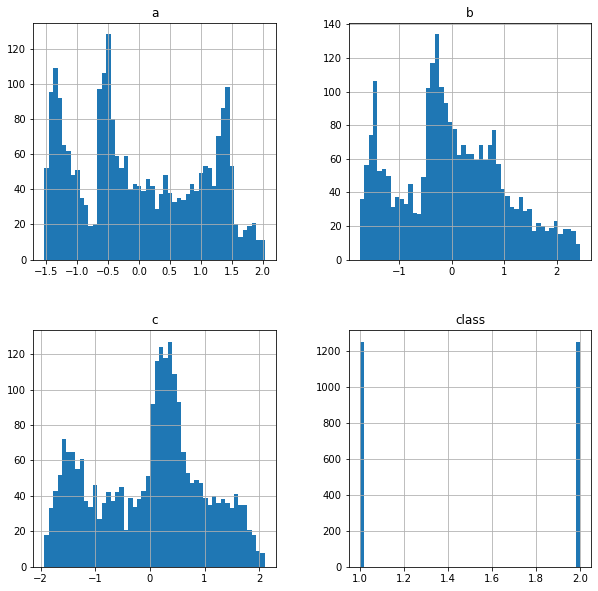

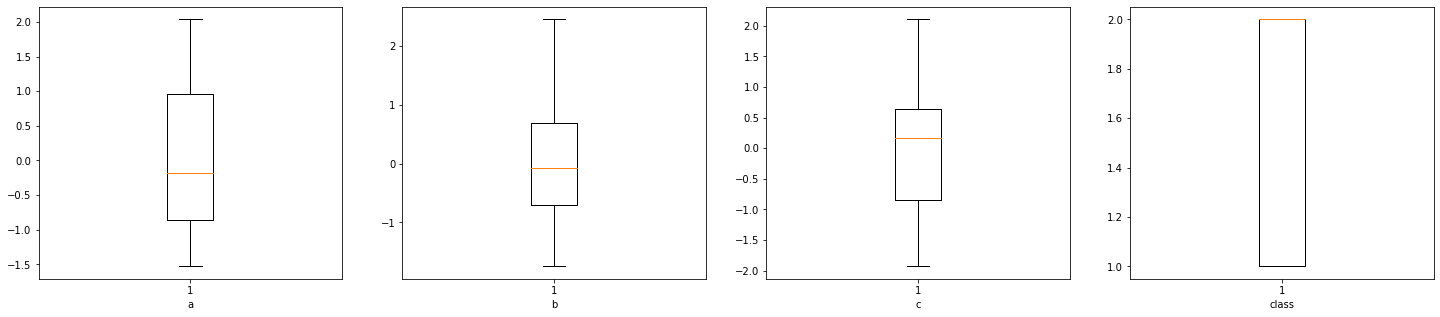

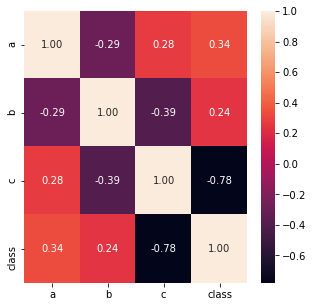

In [28]:
eda = EDA(df_scaled)

In [29]:
df_scaled['class'].value_counts()

2    1251
1    1249
Name: class, dtype: int64

In [30]:
X = df_scaled[['a', 'b', 'c']].values
y = df_scaled[['class']].values

### Question 1: Decisition Tree Classifier
- A simple DT implementation (10 pts.)
    - to make the problem simple, implement a decision tree with depth of 3 (the root index is 0).
    - calculate the gini index for each attribute and pick the best attribute for each node.
    - calculate the accuracy using accuracy score. 
- Classification using DecistionTreeClassifier (5 pts)
- Evaluation (5 pts)

In [31]:
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.left = None #initialize the nodes.  These will be filled after recursive calls
        self.right = None
        self.feature_idx = 0
        self.threshold = 0

In [32]:
class DTClassifier:
    def __init__(self, X, y, max_depth = 3, root_index = 0):
        self.X = X
        self.y = y
        self.max_depth = max_depth
        self.current_depth = 0
        self.root_index = root_index
        self.unique_classes = np.unique(y)
        self.num_features = X.shape[1]
        self.class_value_counts = [np.sum(self.y == c) for c in np.unique(y)]
        self.tree = self.fit(X, y)
    def calculate_gini(self, sample):
        proportions = {}
        sample_size = len(sample)
        for c in self.unique_classes:
            c_count = np.sum(sample == c)
            proportions[c] = c_count/sample_size
        gini_index = (1.0 - sum([i**2 for i in proportions.values()])) * (sample_size / len(self.y))
        return gini_index
    def split(self, X, y):
        if len(y) <=1: #because there is not enought to split
            return None, None
        class_count = [np.sum(y == c) for c in self.unique_classes]
        best_gini = self.calculate_gini(y)
        best_threshold, best_idx = None, None
        for column_idx in range(self.num_features): 
            feature_values = X[:, column_idx]
            temp_concat = pd.DataFrame()
            temp_concat['target'] = y.ravel()
            temp_concat['feature'] = feature_values
            temp_concat = temp_concat.sort_values(by = 'feature', ascending = False)
            feature_values = temp_concat['feature'].values
            y_new = temp_concat['target'].values
#             num_left = np.zeros(shape = len(self.unique_classes))
#             num_right = class_count.copy()
            for y_idx in range(1, len(y_new)):
                c = y_new[y_idx]
                sample_left = y_new[: y_idx]
                sample_right = y_new[y_idx:]
                gini_left = self.calculate_gini(sample_left)
                gini_right = self.calculate_gini(sample_right)
                gini_split = (y_idx * gini_left + (len(y) - y_idx) * gini_right) / len(y)
                if gini_split < best_gini:
                    best_gini = gini_split
                    best_idx = column_idx
                    best_threshold = np.mean([feature_values[y_idx-1], feature_values[y_idx]])
                 
        return best_idx, best_threshold
            
    def fit(self, features, target):
        num_samples_per_class = [np.sum(target == c) for c in self.unique_classes]
        predicted_class = self.unique_classes[np.argmax(num_samples_per_class)]
        num_samples = len(target)
        node = Node(
            num_samples_per_class = num_samples_per_class, 
            predicted_class = predicted_class,
            gini = self.calculate_gini(target), 
            num_samples = num_samples
        )
        if self.current_depth < self.max_depth:
            idx, threshold = self.split(features, target)
            if idx is not None:
                idx_left = features[:, idx] < threshold
                features_left = features[idx_left]
                target_left = target[idx_left]
                features_right = features[~idx_left]
                target_right = target[~idx_left]
                node.feature_idx = idx 
                node.threshold = threshold
                node.left = self.fit(features_left, target_left)
                node.right = self.fit(features_right, target_right)
                self.current_depth += 1
        return node
    def predict(self, x):
        return [self._predict(i) for i in x]
    def _predict(self, x):
        node = self.tree
        while node.left:
            if x[node.feature_idx] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    def score(self, X, y):
        y_predict = self.predict(X)
        return accuracy_score(y, y_predict)
        
dtc = DTClassifier(X, y)

In [33]:
dtc_score = dtc.score(X, y)
print(f'Custom DecisionTree Score {dtc_score}')
metrics_dict['model_type'].append('Custom DecisionTreeClassifier')
metrics_dict['score'].append(dtc_score)

Custom DecisionTree Score 0.9296


In [34]:
##sklearn implementation
sklearn_dtc = DecisionTreeClassifier(max_depth = 3, random_state = random_state)
sklearn_dtc.fit(X, y)
sklearn_dt_score = sklearn_dtc.score(X, y)
metrics_dict['model_type'].append('Sklearn DecisionTreeClassifier')
metrics_dict['score'].append(sklearn_dt_score)

In [35]:
print(f'Sklearn DecisionTreeClassifier Score: {sklearn_dt_score}')

Sklearn DecisionTreeClassifier Score: 0.9996


### Question 2: Random Forest Classifier
- A simle RF implementation (10 pts)
    - make a bootstrap baggin function to make 3 samples.
    - for each sample, run a simple DT from question 1.
    - then average the accuracy. 
- Classification using RandomForestClassifier (5 pts)
- Evaluation (5 pts)

In [36]:
class RFClassifier:
    def __init__(self, X, y, ratio = 1.0, num_trees = 10):
        self.ratio = ratio
        self.num_trees = num_trees
        self.X = X 
        self.y = y
        self.unique_classes = np.unique(y)
        self.fit()
        
    def score(self, X, y):
        tree_predictions = self.predict(X)
        parsed_predictions = [self._parse_tree_predictions(idx, tree_predictions) for idx in range(len(y ))]
        return accuracy_score(y, parsed_predictions)
    
    def _parse_tree_predictions(self, idx, tree_predictions):
        predictions = [tree_predict[idx] for tree_predict in tree_predictions]
        best = np.argmax([np.sum(predictions == c) for c in self.unique_classes])
        best_class = self.unique_classes[best]
        
        return best_class
    def _get_sample(self, X, y):
        sample_idx = np.random.choice(a = X.shape[0], size = X.shape[0], replace = True)
        return X[sample_idx], y[sample_idx]
    
    def fit(self):
        samples = [self._get_sample(self.X, self.y) for _ in range(self.num_trees)]
        self.trees = [DTClassifier(X, y) for (X, y) in samples]

    def predict(self, X):
        return [tree.predict(X) for tree in self.trees]

    
rf = RFClassifier(X, y, num_trees = 3)
rf_score = rf.score(X, y)
print(f'Custom RF Classifier {rf_score}')
metrics_dict['model_type'].append(f'Custom RandomForestClassifier')
metrics_dict['score'].append(rf_score)
# metrics_dict['model_type'].append(f'')

Custom RF Classifier 0.9996


In [37]:
sklearn_rf = RandomForestClassifier(random_state = random_state, max_samples = 3)
sklearn_rf.fit(X, y)
sklearn_rf_score = sklearn_rf.score(X, y)
metrics_dict['model_type'].append('Sklearn RandomForestClassifier')
metrics_dict['score'].append(sklearn_rf_score)
print(f'Sklearn RF Score: {sklearn_rf_score}')

Sklearn RF Score: 0.9976


### Question 3: AdaBoost Classifier
- AB implementation (15 pts)
- Classification using AdaBoostClassifier (5 pts)
- Evaluation (5 pts)

In [38]:
class AdaBoost:
    def __init__(self, X, y, n_estimators = 5):
        self.X = X
        self.y = y
        self.n_estimators = n_estimators
        self.prediction_errors = []
        self.unique_classes = np.unique(y)
        self.w = np.ones(len(y)) * 1 / len(y)
        self.alphas = []
        self.classifier_list = []
        self.fit()
    
    def get_alpha(self, error):
        return np.log((1 - error) / error)
    
    def get_error(self, y_pred):
        return (sum(self.w * (np.not_equal(self.y, y_pred)).astype(int))) / sum(self.w)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    
    def update_weights(self, y_pred, alpha):
#         not_equal = [y_pred[idx] for idx in range(len(y_pred)) if y_pred[idx] != y[idx]]
        not_equal = [1 if y_pred[idx] == y[idx] else 0 for idx in range(len(y_pred))]
        self.w = self.w * np.exp(alpha * not_equal)
        
    def fit(self):
        self.alphas = []
        self.training_errors = []
        for _ in range(self.n_estimators):
            clf = DecisionTreeClassifier(max_depth = 1)
            print('WEIGHTS', self.w)
            print('~' * 100)
            clf.fit(X, y, sample_weight = self.w)
            y_pred = clf.predict(X)
            error = self.get_error(y_pred)
            alpha = self.get_alpha(error)
            self.alphas.append(alpha)
            self.update_weights(y_pred, alpha) 
            self.classifier_list.append(clf)
    
    def get_final_votes(self, votes): 
        return np.argmax([np.sum(votes == i) for i in self.unique_classes])
    
    def predict(self, X):
        predictions = np.zeros(shape = (len(X), self.n_estimators))
        for idx, clf in enumerate(self.classifier_list):
            predict = clf.predict(X)
            predictions[:, idx] = predict
        predictions = pd.DataFrame(predictions)
        final_predictions = [self.unique_classes[self.get_final_votes(row.values)]
                            for idx, row in predictions.iterrows()]
        return final_predictions
    
ada = AdaBoost(X, y)
ada_score = ada.score(X, y)
print(f'Custom Ada Score: {ada_score}')
metrics_dict['model_type'].append('Custom AdaBoostClassifier')
metrics_dict['score'].append(ada_score)

WEIGHTS [0.0004 0.0004 0.0004 ... 0.0004 0.0004 0.0004]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
WEIGHTS [0.00039936 0.00039936 0.00039936 ... 0.00040064 0.00040064 0.00040064]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
WEIGHTS [0.00039989 0.00039989 0.00039989 ... 0.00039989 0.00039989 0.00039989]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
WEIGHTS [0.00039927 0.00039927 0.00039927 ... 0.00040055 0.00040055 0.00040055]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
WEIGHTS [0.00039982 0.00039982 0.00039982 ... 0.00039982 0.00039982 0.00039982]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Custom Ada Score: 0.9032


In [39]:
sklearn_ada = AdaBoostClassifier(random_state = random_state)
sklearn_ada.fit(X, y)
sklearn_ada_score = sklearn_ada.score(X, y)
metrics_dict['model_type'].append('Sklearn AdaBoostClassifier')
metrics_dict['score'].append(sklearn_ada_score)
print(f'Sklearn AdaBoost Score: {sklearn_ada_score}')

Sklearn AdaBoost Score: 1.0


### Question 4: Gradient Boost Classifier
- GB implementation (15 pts)
- Classification using GradientBoostingClassifier (5 pts)
- Evaluation (5 pts)

In [40]:
class GradientBoost:
    def __init__(self, X, y, n_estimators = 10, learning_rate = .1):
        self.X = X
        self.y = y
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.unique_classes = np.unique(y)
        self.classifier_list = []
        self.previous_prob = []
        self.fit()
        
    
    def fit(self):
        for idx in range(self.n_estimators): 
            clf = DecisionTreeClassifier(max_depth = 2)
            if idx == 0:
                clf.fit(X, y)
                y_pred = clf.predict_proba(X)
            else:
                prev = self.previous_prob[idx -1]
                clf.fit(X, prev)
                y_pred = clf.predict_proba(X) * self.learning_rate
            y_pred = [self.unique_classes[i] for i in np.argmax(y_pred, axis = 1)]

            self.previous_prob.append(y_pred)
            self.classifier_list.append(clf)
        

    def score(self, X, y):
        predictions = self.predict(X)
        return accuracy_score(y, predictions)
    def get_final_votes(self, votes): 
        return np.argmax([np.sum(votes == i) for i in self.unique_classes])
    def predict(self, X):
        model_predictions = []
        predictions = np.zeros(shape = (len(X), self.n_estimators))
        for idx, clf in enumerate(self.classifier_list):
            predict = clf.predict(X)
            predictions[:, idx] = predict
        predictions = pd.DataFrame(predictions)
        final_predictions = [self.unique_classes[self.get_final_votes(row.values)]
                            for idx, row in predictions.iterrows()]
        return final_predictions
    
gradient_boost = GradientBoost(X, y, n_estimators = 100)
gradient_score = gradient_boost.score(X, y)
print(f'Gradient Score: {gradient_score}')
metrics_dict['model_type'].append(f'Custom GradientBoostClassifier')
metrics_dict['score'].append(gradient_score)

Gradient Score: 0.9412


In [41]:
sklearn_gradient = GradientBoostingClassifier(random_state = random_state)
sklearn_gradient.fit(X, y)
sklearn_gradient_score = sklearn_gradient.score(X, y)
metrics_dict['model_type'].append('Sklearn GradientBoostClassifier')
metrics_dict['score'].append(sklearn_gradient_score)
print(f'Sklearn GradientBoost Score: {sklearn_gradient_score}')

Sklearn GradientBoost Score: 1.0


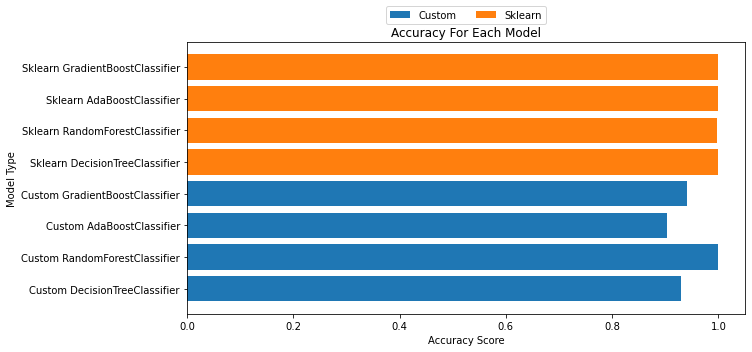

In [42]:
metric_df = pd.DataFrame(metrics_dict, index = [i for i in range(len(metrics_dict['score']))])
custom_df = pd.concat([pd.DataFrame(row).transpose() for idx, row in metric_df.iterrows() 
                       if 'Custom' in row.model_type])
sklearn_df = pd.concat([pd.DataFrame(row).transpose() for idx, row in metric_df.iterrows() 
                        if 'Sklearn' in row.model_type])
plt.figure(figsize=(10, 5))
plt.barh(custom_df.model_type.values, custom_df.score.values, label = 'Custom')
plt.barh(sklearn_df.model_type.values, sklearn_df.score.values, label = 'Sklearn')
plt.title('Accuracy For Each Model')
plt.ylabel('Model Type')
plt.xlabel('Accuracy Score')
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)